---

In [31]:
import pandas as pd
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\duyen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
# Extract word vectors
word_embeddings = {}
file = open('../glove.6B.200d.txt', encoding='utf-8')
for line in file:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
file.close()
len(word_embeddings)

400000

In [33]:
def remove_stopwords(sen):
    stop_words = stopwords.words('english')
    
    sen_new = " ".join([i for i in sen if i not in stop_words])
    return sen_new

In [34]:
def sentence_vector_func (sentences_cleaned) : 
    sentence_vector = []
    for i in sentences_cleaned:
        if len(i) != 0:
            v = sum([word_embeddings.get(w, np.zeros((200,))) for w in i.split()])/(len(i.split())+0.001)
        else:
            v = np.zeros((200,))
        sentence_vector.append(v)
    
    return (sentence_vector)

In [38]:
def summary_text (test_text, per):
    sentences = []
    
    # tokenising the text 
    sentences.append(sent_tokenize(test_text))
    # print(sentences)
    sentences = [y for x in sentences for y in x] # flatten list
    # print(sentences)
    
    # remove punctuations, numbers and special characters
    clean_sentences = pd.Series(sentences).str.replace("[^a-z A-Z 0-9]", " ")

    # make alphabets lowercase
    clean_sentences = [s.lower() for s in clean_sentences]
    #print(clean_sentences)

    
    # remove stopwords from the sentences
    clean_sentences = [remove_stopwords(r.split()) for r in clean_sentences]
    #print(clean_sentences)
    
    sentence_vectors = sentence_vector_func(clean_sentences)
    
    # similarity matrix
    sim_mat = np.zeros([len(sentences), len(sentences)])
    #print(sim_mat)
    
    # Finding the similarities between the sentences 
    for i in range(len(sentences)):
        for j in range(len(sentences)):
            if i != j:
                sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,200), sentence_vectors[j].reshape(1,200))[0,0]
    
    
    nx_graph = nx.from_numpy_array(sim_mat)
    scores = nx.pagerank(nx_graph)
    #print(scores)
    n  = int(len(sentences)*per)
    ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)))
    # Extract sentences as the summary
    summarised_string = ''
    for i in range(n):
        
        try:
            summarised_string = summarised_string +'\n'+ str(ranked_sentences[i][1])            
        except IndexError:
            print ("Summary Not Available")
    
    return (summarised_string), ranked_sentences

In [39]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def build_similarity_matrix(sentences):
    vectorizer = CountVectorizer().fit_transform(sentences)
    vectors = vectorizer.toarray()
    similarity_matrix = cosine_similarity(vectors)
    return similarity_matrix

def draw_graph(sentences, scores, threshold=0.2):
    G = nx.Graph()
    
    for i, sentence in enumerate(sentences):
        G.add_node(i, label=sentence[:20])  # Chỉ lấy 20 ký tự đầu tiên của mỗi câu để làm nhãn
        
    for i in range(len(sentences)):
        for j in range(i + 1, len(sentences)):
            if scores[i][j] > threshold:
                G.add_edge(i, j, weight=scores[i][j])
    
    pos = nx.spring_layout(G)
    
    plt.figure(figsize=(5, 5))
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color="skyblue")
    nx.draw_networkx_edges(G, pos, width=2, alpha=0.5, edge_color="gray")
    nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

    plt.title("Text Similarity Graph")
    plt.show()


In [41]:
text = '''The quality, type, and density of information conveyed via text varies from source to source. Textbooks tend to be low in density but high in quality, while academic articles are high in both quality and density. On the other hand, news articles can vary significantly from source to source. Regardless of where the text comes from the goal here is to minimize the time you spend reading. Thus, we will build a tool that can easily be adapted to any number of sources.'''

# summary = summary_text(text, 0.4)

# summary_sentences = summary.split('. ')
# formatted_summary = '.\n'.join(summary_sentences)

# print(formatted_summary)
summary_text(text, 0.4)


('\nTextbooks tend to be low in density but high in quality, while academic articles are high in both quality and density.\nThus, we will build a tool that can easily be adapted to any number of sources.',
 [(0.19617699371490877,
   'Textbooks tend to be low in density but high in quality, while academic articles are high in both quality and density.'),
  (0.19709955365284648,
   'Thus, we will build a tool that can easily be adapted to any number of sources.'),
  (0.19875985342123767,
   'Regardless of where the text comes from the goal here is to minimize the time you spend reading.'),
  (0.19943561746115976,
   'The quality, type, and density of information conveyed via text varies from source to source.'),
  (0.20852798174984727,
   'On the other hand, news articles can vary significantly from source to source.')])

C:\Users\duyen\AppData\Local\Temp\ipykernel_10520\1432463893.py:27: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=2, alpha=0.5, edge_color="gray")


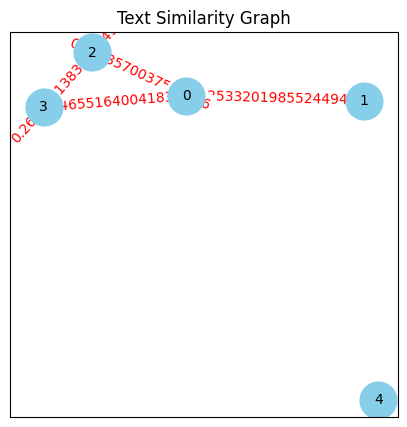

In [30]:
# Tokenize the text into sentences
sentences = [sentence.strip() for sentence in text.split('.') if sentence.strip()]

# Build similarity matrix
similarity_matrix = build_similarity_matrix(sentences)

# Draw the graph
draw_graph(sentences, similarity_matrix)

---

In [13]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from heapq import nlargest

In [11]:
def summarize(text, per):
    nlp = spacy.load('en_core_web_sm')
    doc= nlp(text)
    # tạo từ điển để lưu lại tần số các từ
    word_frequencies={}
    for word in doc:
        if word.text.lower() not in list(STOP_WORDS):
            if word.text.lower() not in punctuation:
                if word.text not in word_frequencies.keys():
                    word_frequencies[word.text] = 1
                else:
                    word_frequencies[word.text] += 1
    #chuẩn hóa từ bằng cách chia tần suất max
    max_frequency=max(word_frequencies.values())
    for word in word_frequencies.keys():
        word_frequencies[word]=word_frequencies[word]/max_frequency
    sentence_tokens= [sent for sent in doc.sents]
    # tính điểm = tổng tần suất từ trong câu
    sentence_scores = {}
    for sent in sentence_tokens:
        for word in sent:
            if word.text.lower() in word_frequencies.keys():
                if sent not in sentence_scores.keys():                            
                    sentence_scores[sent]=word_frequencies[word.text.lower()]
                else:
                    sentence_scores[sent]+=word_frequencies[word.text.lower()]
    # xác định số câu và in ra các câu có số điểm từ cao nhất
    select_length=int(len(sentence_tokens)*per)
    summary=nlargest(select_length, sentence_scores,key=sentence_scores.get)
    final_summary=[word.text for word in summary]
    summary=' '.join(final_summary)
    return summary

In [14]:
text = '''The quality, type, and density of information conveyed via text varies from source to source. Textbooks tend to be low in density but high in quality, while academic articles are high in both quality and density. On the other hand, news articles can vary significantly from source to source. Regardless of where the text comes from the goal here is to minimize the time you spend reading. Thus, we will build a tool that can easily be adapted to any number of sources.'''

summary = summarize(text, 1)

summary_sentences = summary.split('. ')
formatted_summary = '.\n'.join(summary_sentences)

print("summary :")
print(formatted_summary)

summary :
Textbooks tend to be low in density but high in quality, while academic articles are high in both quality and density.
The quality, type, and density of information conveyed via text varies from source to source.
On the other hand, news articles can vary significantly from source to source.
Regardless of where the text comes from the goal here is to minimize the time you spend reading.
Thus, we will build a tool that can easily be adapted to any number of sources.


In [44]:
len(summary)

464

In [45]:
len(text)

468

---

In [6]:
import spacy
import networkx as nx
from spacy.lang.en.stop_words import STOP_WORDS

def preprocess_text(text):
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(text)
    return [token.text for token in doc if token.text.lower() not in STOP_WORDS]

def build_similarity_matrix(sentences):
    similarity_matrix = nx.Graph()
    for i in range(len(sentences)):
        for j in range(i+1, len(sentences)):
            similarity = len(set(sentences[i]) & set(sentences[j])) / float(len(set(sentences[i]) | set(sentences[j])))
            if similarity > 0:
                similarity_matrix.add_edge(i, j, weight=similarity)
    return similarity_matrix

def textrank_extractive_summarization(text, percent):
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(text)
    
    # Sử dụng thuật toán `sbd` của Spacy để tách văn bản thành các câu
    sentences = [preprocess_text(sent.text) for sent in doc.sents]
    
    similarity_matrix = build_similarity_matrix(sentences)
    
    scores = nx.pagerank(similarity_matrix)
    ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
    
    num_sentences = int(len(sentences) * percent)
    selected_sentences = nlargest(num_sentences, ranked_sentences, key=lambda x: x[0])
    
    # Kết hợp các câu được chọn để tạo thành tóm tắt
    summary = ' '.join([' '.join(sent[1]) for sent in selected_sentences])
    return summary



In [7]:
text = '''The quality, type, and density of information conveyed via text varies from source to source. Textbooks tend to be low in density but high in quality, while academic articles are high in both quality and density. On the other hand, news articles can vary significantly from source to source. Regardless of where the text comes from the goal here is to minimize the time you spend reading. Thus, we will build a tool that can easily be adapted to any number of sources.'''

summary = textrank_extractive_summarization(text, 0.4)

summary_sentences = summary.split('. ')
formatted_summary = '.\n'.join(summary_sentences)

print("summary :")
print(formatted_summary)

NameError: name 'nlargest' is not defined